In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
# provider = IBMQ.get_provider(hub='ibm-q-education', group='yale-uni-2', project='cpsc647-quantum')
# device = provider.get_backend('ibmq_lima') #run on ibmq_lima (5-qbit QC)

In [2]:
# device_names =  ['ibmq_lima', 'ibmq_bogota', 'ibmq_santiago', 'ibmq_manila', 'ibmq_quito', 'ibmq_belem', 'ibmq_casablanca', 'ibmq_jakarta', 'ibm_lagos', 'ibm_perth'  ]
device_names =  ['ibmq_lima', 'ibmq_bogota', 'ibmq_santiago', 'ibmq_manila', 'ibmq_quito', 'ibmq_belem']
device = [0]*len(device_names)
for i in range(len(device_names)):
    device[i] = provider.get_backend(device_names[i])
    print("Device", i , "=", device[i])


Device 0 = ibmq_lima
Device 1 = ibmq_bogota
Device 2 = ibmq_santiago
Device 3 = ibmq_manila
Device 4 = ibmq_quito
Device 5 = ibmq_belem


In [4]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate


def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

def dj_mal(copies, mal_type):
    oracle = dj_oracle("balanced",2)
#     oracle = dj_oracle("constant",2)
#     dj_circuit = QuantumCircuit(7, 6)
#     dj_circuit = QuantumCircuit(5, 4)
    
    if (mal_type == 'M10' or mal_type == 'M11'):
        qr = n+5
        cr = qr-1
    
    elif (mal_type == 'M9'):
        qr = n+4
        cr = qr - 1
        
    elif (mal_type == 'M12' or mal_type == 'M0'):
        qr = n + 1 
        cr = qr-1
    else:
        qr = n+3 
        cr = qr-1
    
    dj_circuit = QuantumCircuit(qr, cr)
    
    dj_circuit.barrier()
    # Set up the output qubit:
    dj_circuit.x(2)
    dj_circuit.h(2)
    # And set up the input register:
    for qubit in range(2):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    
#     dj_circuit.append(oracle, range(2+1))
    dj_circuit.append(oracle, [0,1,2])
    # Finally, perform the H-gates again and measure:
    for qubit in range(2):
        dj_circuit.h(qubit)
    
#     for i in range(copies):
# #         dj_circuit.z(3)
#         dj_circuit.cx(3,4)
# #         dj_circuit.h(3)
# #         dj_circuit.delay(0, qarg = 3)
# #         dj_circuit.h(3)
# #         dj_circuit.delay(0, qarg = 3)
#         dj_circuit.cx(4,3)
# #         dj_circuit.delay(0, qarg = 3)

# #         if i%2==1:
# #             dj_circuit.cx(4,3)
# #             dj_circuit.cx(5,4)
# #             dj_circuit.cx(6,5)
# #             dj_circuit.delay(0, qarg = 6)
# #         else:
# #             dj_circuit.cx(6,5)
# #             dj_circuit.cx(5,4)
# #             dj_circuit.cx(4,3)
# #             dj_circuit.delay(0, qarg = 3)

############ MALICIOUS CIRCUIT #####################
    if (mal_type == 'M12'):
        dj_circuit.barrier()
        dj_circuit.delay(5*10**copies, unit = 'dt')
    
    else:
        for i in range(copies):
            if (mal_type == 'M1'):
                dj_circuit.cx(3,4)

            if (mal_type == 'M2'):
                dj_circuit.cx(3,4)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M3'):
                dj_circuit.cx(3,4)
                dj_circuit.delay(0, qarg=3, unit = 'dt')
                dj_circuit.cx(4,3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M4'):
                dj_circuit.cx(3,4)
                dj_circuit.h(3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')
                dj_circuit.h(3)

            if (mal_type == 'M5'):
                dj_circuit.x(3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M6'):
                dj_circuit.y(3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M7'):
                dj_circuit.z(3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M8'):
                dj_circuit.h(3)
                dj_circuit.delay(0, qarg=3, unit = 'dt')

            if (mal_type == 'M9'):
                dj_circuit.cx(3,4)
                dj_circuit.cx(4,5)

            if (mal_type == 'M10'):
                if i%2==1:
                    dj_circuit.cx(4,3)
                    dj_circuit.cx(5,4)
                    dj_circuit.cx(6,5)
                    dj_circuit.delay(0, qarg = 6)
                else:
                    dj_circuit.cx(6,5)
                    dj_circuit.cx(5,4)
                    dj_circuit.cx(4,3)
                    dj_circuit.delay(0, qarg = 3)

            if (mal_type == 'M11'):
                dj_circuit.cx(5,6)
                dj_circuit.delay(0, qarg=4, unit = 'dt')


            
####################################################

    dj_circuit.barrier()
    # Measurement
#     for i in range(n):
#         bv_circuit.measure(i, i)
    dj_circuit.measure(0, 0)
    dj_circuit.measure(1, 1)
    
    if (mal_type == 'M9'):
        dj_circuit.measure(3, 2)
        dj_circuit.measure(4, 3)
        dj_circuit.measure(5, 4) 
    
    elif (mal_type == 'M10'):
        dj_circuit.measure(3, 2)
        dj_circuit.measure(4, 3)
        dj_circuit.measure(5, 4)
        dj_circuit.measure(6, 5)
        
    elif (mal_type == 'M0' or mal_type == 'M12'):
        pass
    
    else:
        dj_circuit.measure(3, 2)
        dj_circuit.measure(4, 3)
#     bv_circuit.measure(5, 4)
#     bv_circuit.measure(6, 5)
    
    return dj_circuit

In [5]:
n=2
# oracle = dj_oracle("balanced",n)
# d1 = dj_algorithm(oracle, n)
dj = dj_mal(20, 'M2')

# print(d1)
print(dj)

      ░ ┌───┐                ┌─────────┐     ┌───┐                           »
q_0: ─░─┤ H ├────────────────┤0        ├─────┤ H ├───────────────────────────»
      ░ ├───┤                │         │     ├───┤                           »
q_1: ─░─┤ H ├────────────────┤1 Oracle ├─────┤ H ├───────────────────────────»
      ░ ├───┤     ┌───┐      │         │     └───┘                           »
q_2: ─░─┤ X ├─────┤ H ├──────┤2        ├─────────────────────────────────────»
      ░ └───┘┌────┴───┴─────┐└─────────┘┌──────────────┐     ┌──────────────┐»
q_3: ─░───■──┤ Delay(0[dt]) ├─────■─────┤ Delay(0[dt]) ├──■──┤ Delay(0[dt]) ├»
      ░ ┌─┴─┐└──────────────┘   ┌─┴─┐   └──────────────┘┌─┴─┐└──────────────┘»
q_4: ─░─┤ X ├───────────────────┤ X ├───────────────────┤ X ├────────────────»
      ░ └───┘                   └───┘                   └───┘                »
c: 4/════════════════════════════════════════════════════════════════════════»
                                                    

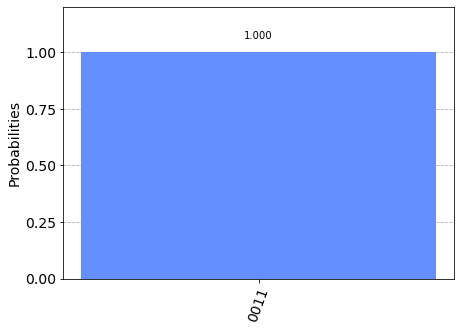

In [6]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_circuit = transpile(dj, aer_sim)
qobj = assemble(transpiled_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

Running on device:  ibmq_lima


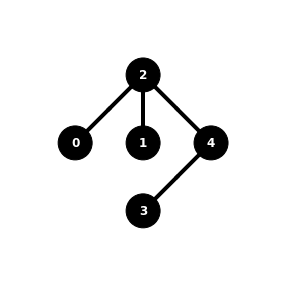

In [8]:
backend = device[0]
print("Running on device: ", backend)
from qiskit.tools.monitor import job_monitor
# transpiled_dj = transpile(dj, backend, optimization_level=3, scheduling_method='alap')

transpiled_dj = transpile(dj, backend, optimization_level=3, scheduling_method='alap', seed_transpiler = 1 )
# transpiled_dj = transpile(dj, backend, optimization_level=3, scheduling_method='alap', seed_transpiler = 10 )

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(transpiled_dj, backend = backend)


In [78]:
job = backend.run(transpiled_dj)
job_monitor(job, interval=2)

Job Status: job is queued (2)     

KeyboardInterrupt: 

In [ ]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)
# winsound.Beep(frequency, 3000)

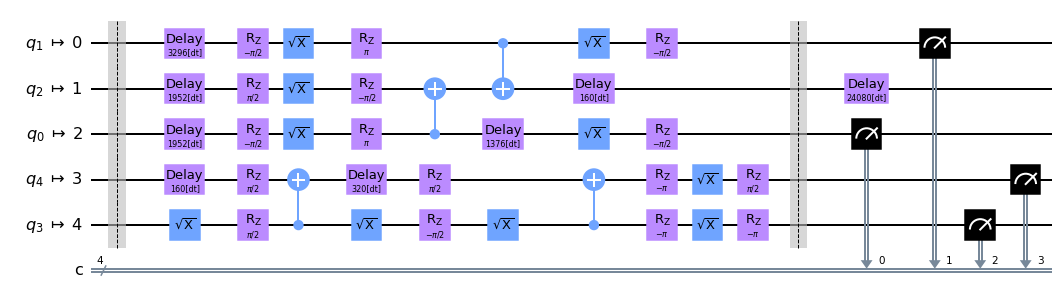

In [45]:
transpiled_dj.draw('mpl')

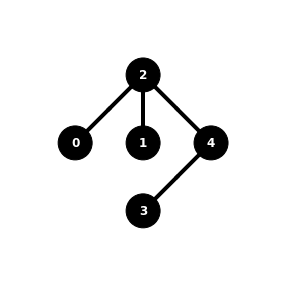

In [22]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
plot_circuit_layout(transpiled_dj, backend = device[0])

In [ ]:
from qiskit.tools.monitor import job_monitor
import winsound
import time

iterations = 200
f = open("DJ_M7.txt", "w")
backend = device[0]
answer= [0]*iterations
f.write(str(backend))
f.write(str("\n"))
for i in range(0,iterations,10):
    dj = dj_mal(i, 'M7')
    print("Running on device: ", backend)
    transpiled_dj = transpile(dj, backend, optimization_level=3, scheduling_method='alap', seed_transpiler=1)
#     transpiled_dj = transpile(dj, backend, optimization_level=0, scheduling_method='alap')
    job = backend.run(transpiled_dj) 
    job_monitor(job, interval=2)

    results = job.result()
    answer[i] = results.get_counts()
    
    prob = int(answer[i]['0011'])/1000
    print(i, prob)
    f.write(str(i))
    f.write(str(", "))
    f.write(str(prob))
    f.write(str("\n"))
    
f.close()


f = open("DJ_M8.txt", "w")
backend = device[0]
answer= [0]*iterations
f.write(str(backend))
f.write(str("\n"))
for i in range(0,iterations,10):
    dj = dj_mal(i, 'M8')
    print("Running on device: ", backend)
    transpiled_dj = transpile(dj, backend, optimization_level=3, scheduling_method='alap', seed_transpiler=1)
#     transpiled_dj = transpile(dj, backend, optimization_level=0, scheduling_method='alap')
    job = backend.run(transpiled_dj) 
    job_monitor(job, interval=2)

    results = job.result()
    answer[i] = results.get_counts()
    
    prob = int(answer[i]['0011'])/1000
    print(i, prob)
    f.write(str(i))
    f.write(str(", "))
    f.write(str(prob))
    f.write(str("\n"))
    
f.close()



# Beeper
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
for i in range(10):
    winsound.Beep(frequency, duration)
    time.sleep(1)

Running on device:  ibmq_lima
Job Status: job has successfully run
0 0.826
Running on device:  ibmq_lima
Job Status: job has successfully run
10 0.826
Running on device:  ibmq_lima
Job Status: job has successfully run
20 0.852
Running on device:  ibmq_lima
Job Status: job has successfully run
30 0.831
Running on device:  ibmq_lima
Job Status: job has successfully run
40 0.821
Running on device:  ibmq_lima
Job Status: job has successfully run
50 0.832
Running on device:  ibmq_lima
Job Status: job has successfully run
60 0.816
Running on device:  ibmq_lima
Job Status: job has successfully run
70 0.813
Running on device:  ibmq_lima
Job Status: job is queued (22)    

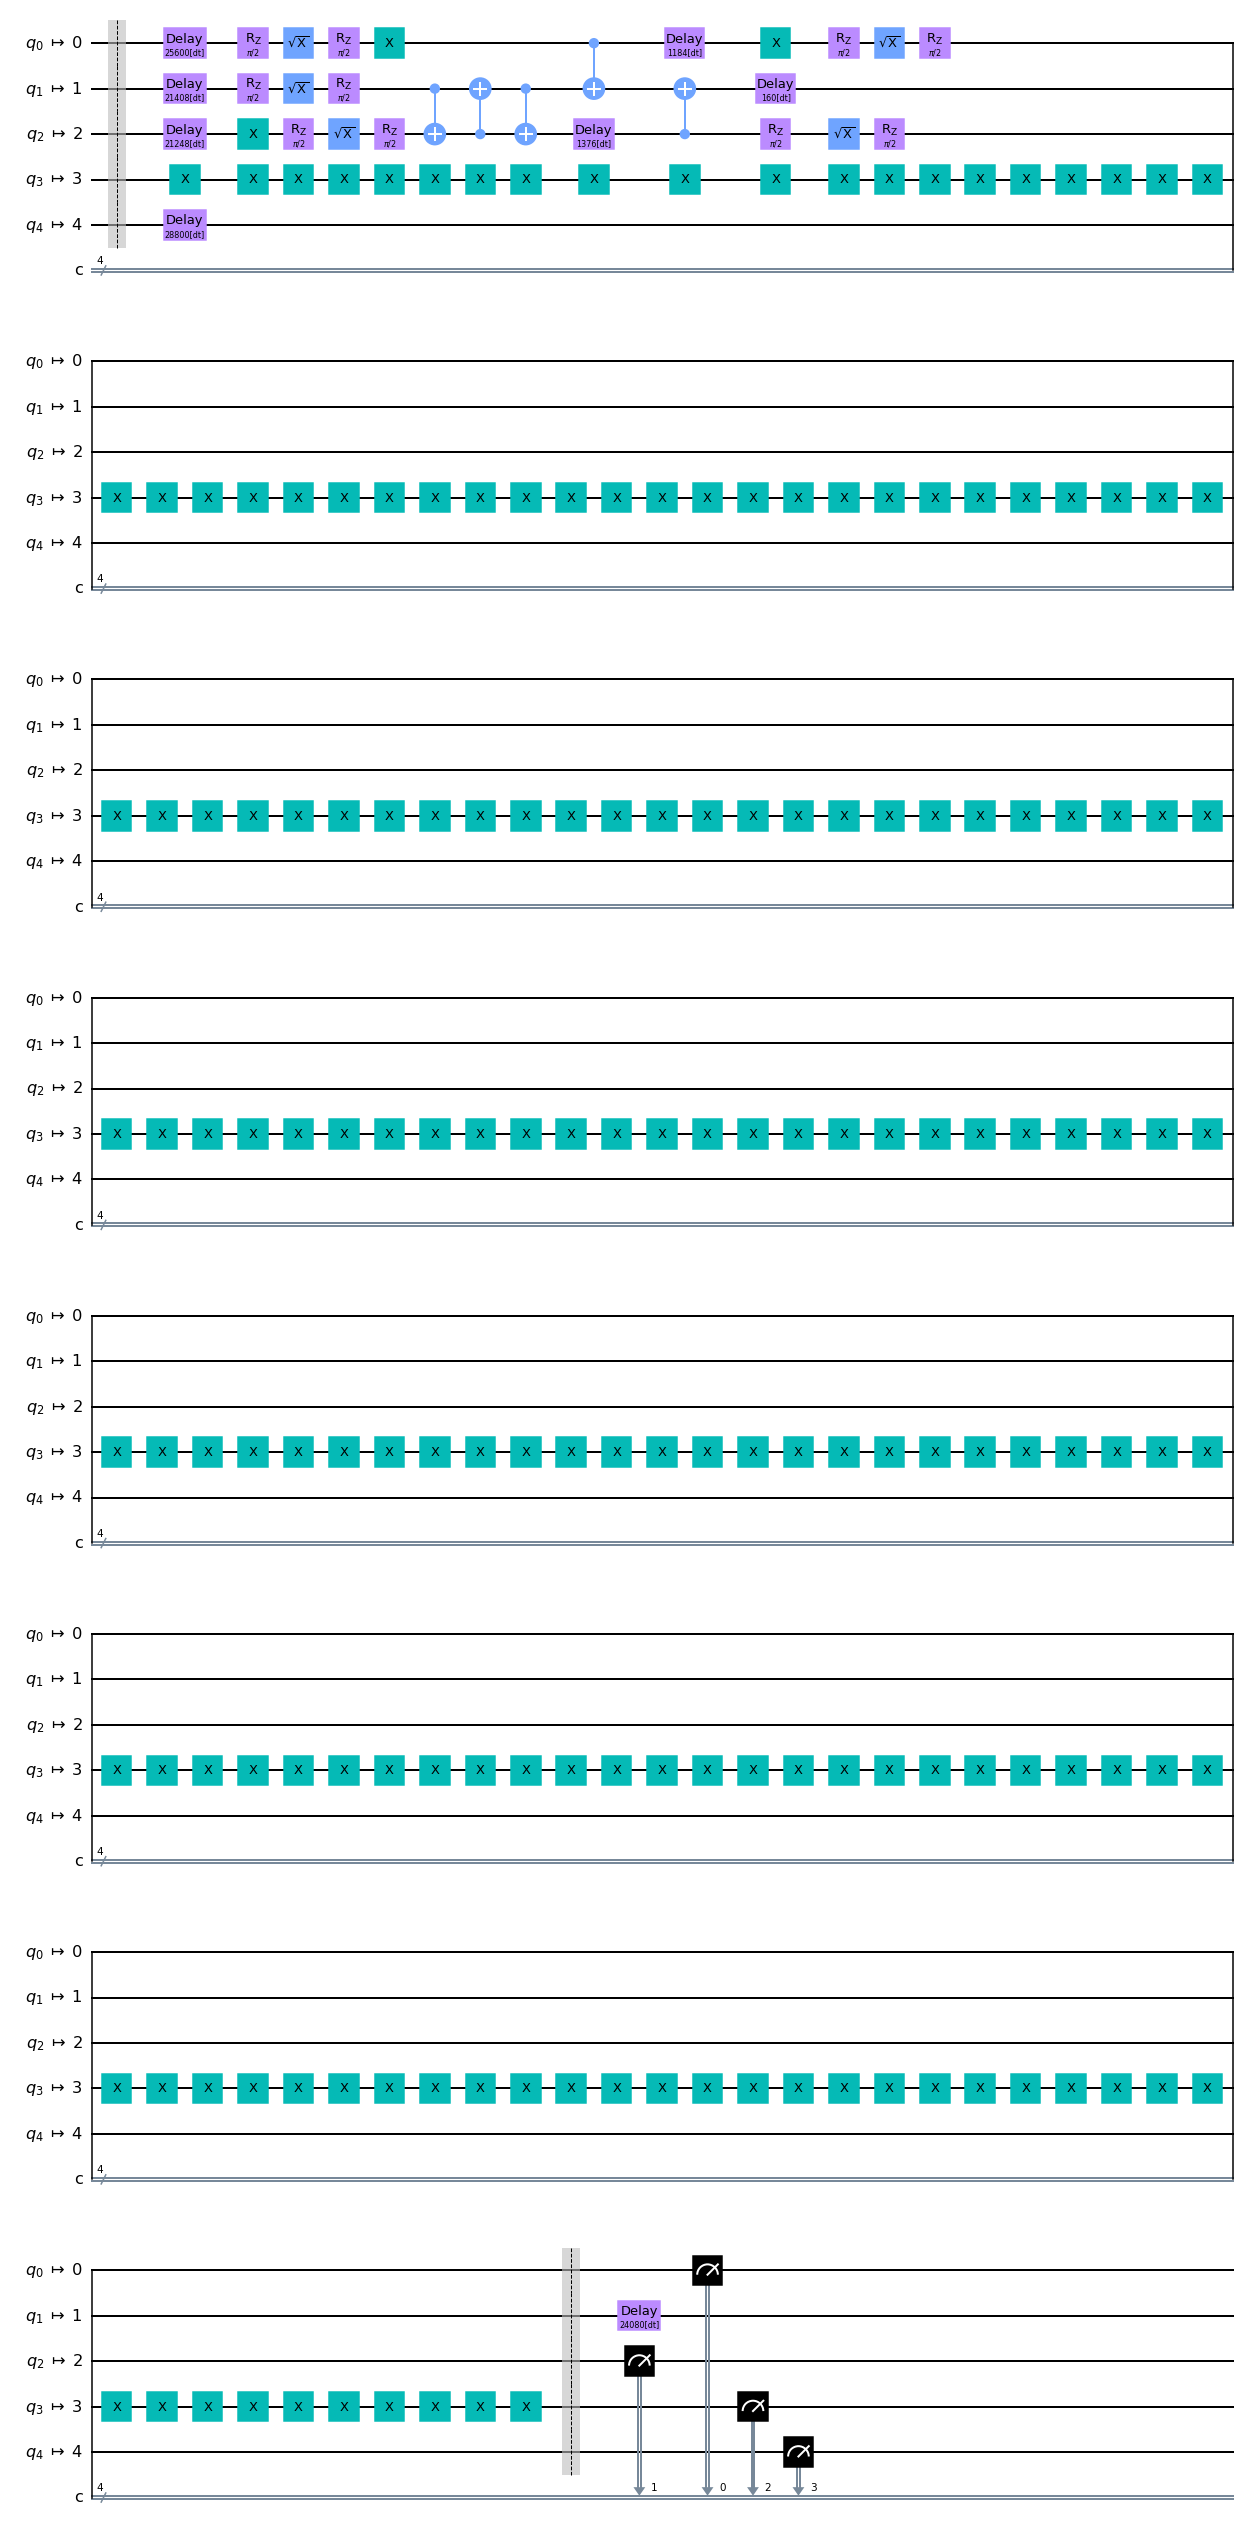

In [127]:
transpiled_dj.draw('mpl')

In [9]:
transpiled_dj = [0]*len(device)
for i in range(len(device)):
    print("============================================")
    print(device[i])
    transpiled_dj[i] = transpile(dj, device[i], optimization_level=3, scheduling_method='alap')
    print(transpiled_dj[i])
    print("============================================")

ibmq_lima
               ┌──────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(28816[dt]) ├─────────────────────────────────»
               ├─────────────────┬┘┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 1 ┤ Delay(2176[dt]) ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┴┐└──────────┘   └────┘   └───────┘»
ancilla_1 -> 2 ┤ Delay(28816[dt]) ├─────────────────────────────────»
               └───┬─────────┬────┘   ┌────┐   ┌──────────┐  ┌───┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├────────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
                   ├─────────┴┐       ├────┤   └┬───────┬─┘  └─┬─┘  »
      q_0 -> 4 ────┤ Rz(-π/2) ├───────┤ √X ├────┤ Rz(π) ├──────■────»
                   └──────────┘       └────┘    └───────┘           »
          c: 2/═════════════════════════════════════════════════════»
                                                                    »
«                                                                        
«ancil

               ┌──────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(28848[dt]) ├─────────────────────────────────»
               ├─────────────────┬┘┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 1 ┤ Delay(2496[dt]) ├─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┴┐└──────────┘   └────┘   └───────┘»
ancilla_1 -> 2 ┤ Delay(28848[dt]) ├─────────────────────────────────»
               └───┬─────────┬────┘   ┌────┐   ┌──────────┐  ┌───┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├────────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
                   ├─────────┴┐       ├────┤   └┬───────┬─┘  └─┬─┘  »
      q_0 -> 4 ────┤ Rz(-π/2) ├───────┤ √X ├────┤ Rz(π) ├──────■────»
                   └──────────┘       └────┘    └───────┘           »
          c: 2/═════════════════════════════════════════════════════»
                                                                    »
«                                                                        
«ancilla_0 -> 0 

               ┌─────────────────┐                                 »
ancilla_0 -> 0 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               └───┬──────────┬──┘   ┌────┐    ┌───────┐           »
      q_0 -> 1 ────┤ Rz(-π/2) ├──────┤ √X ├────┤ Rz(π) ├──────■────»
               ┌───┴──────────┴──┐   └────┘    └───────┘      │    »
ancilla_1 -> 2 ┤ Delay(6624[dt]) ├────────────────────────────┼────»
               └───┬─────────┬───┘   ┌────┐   ┌──────────┐  ┌─┴─┐  »
      q_2 -> 3 ────┤ Rz(π/2) ├───────┤ √X ├───┤ Rz(-π/2) ├──┤ X ├──»
               ┌───┴─────────┴───┐   └────┘   └──────────┘  └───┘  »
ancilla_2 -> 4 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               ├─────────────────┤┌──────────┐   ┌────┐   ┌───────┐»
      q_1 -> 5 ┤ Delay(1824[dt]) ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π) ├»
               ├─────────────────┤└──────────┘   └────┘   └───────┘»
ancilla_3 -> 6 ┤ Delay(6624[dt]) ├─────────────────────────────────»
               └─────────────────┘

ibm_perth


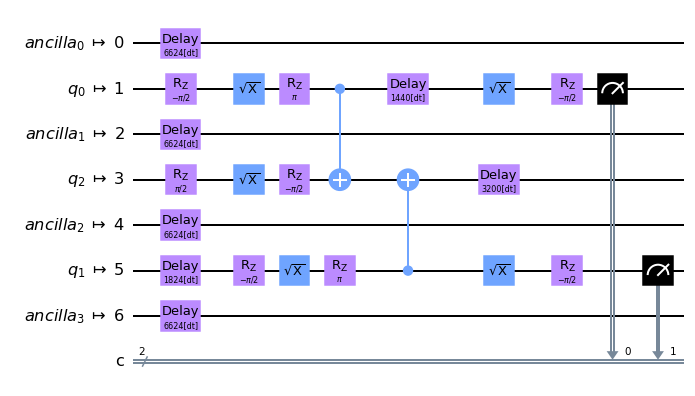

In [22]:
j = 9
print(device[j])
transpiled_dj[j].draw('mpl')

In [120]:
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.compiler import transpile

qcx = QuantumCircuit(2)
# qcx.cx(0,1)
# qcx.x(0)
qcx.z(0)

print("============================================")
print(device[0])
transpiled_qcx = transpile(qcx, device[0], optimization_level=3, scheduling_method='alap')
print(transpiled_qcx)
print(circuit_to_dag(transpiled_qcx))
print("============================================")


ibmq_lima
               ┌───────┐
      q_0 -> 0 ┤ Rz(π) ├
               └───────┘
      q_1 -> 1 ─────────
                        
ancilla_0 -> 2 ─────────
                        
ancilla_1 -> 3 ─────────
                        
ancilla_2 -> 4 ─────────
                        


In [121]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

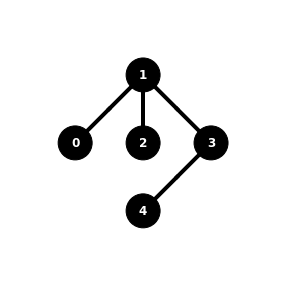

In [106]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.test.mock import FakeVigo
from qiskit.transpiler import CouplingMap
# backend=device[9]
# qplot = transpile(ghz, backend, scheduling_method='alap')
# print("========",backend,"========")
plot_circuit_layout(transpiled_dj, backend)

In [24]:
import winsound
import time
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
for i in range(10):
    winsound.Beep(frequency, duration)
    time.sleep(1)
    

KeyboardInterrupt: 